In [1]:
%pip install opencv-python==3.4.2.16
%pip install opencv-contrib-python==3.4.2.16
%pip install matplotlib
%pip install scikit-learn
%pip install scikit-image
%pip install imutils

  Using cached opencv_python-3.4.2.16-cp36-cp36m-win_amd64.whl (33.8 MB)
Note: you may need to restart the kernel to use updated packages.  Using cached numpy-1.19.5-cp36-cp36m-win_amd64.whl (13.2 MB)



Reason for being yanked: Release deprecated


  Using cached opencv_contrib_python-3.4.2.16-cp36-cp36m-win_amd64.whl (39.6 MB)
Note: you may need to restart the kernel to use updated packages.


Reason for being yanked: Release deprecated


  Using cached matplotlib-3.3.4-cp36-cp36m-win_amd64.whl (8.5 MB)
  Using cached pyparsing-3.1.4-py3-none-any.whl (104 kB)
  Using cached kiwisolver-1.3.1-cp36-cp36m-win_amd64.whl (51 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached Pillow-8.4.0-cp36-cp36m-win_amd64.whl (3.2 MB)
Note: you may need to restart the kernel to use updated packages.
  Using cached scikit_learn-0.24.2-cp36-cp36m-win_amd64.whl (6.8 MB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached scipy-1.5.4-cp36-cp36m-win_amd64.whl (31.2 MB)
  Using cached joblib-1.1.1-py2.py3-none-any.whl (309 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached scikit_image-0.17.2-cp36-cp36m-win_amd64.whl (11.5 MB)

  Using cached tifffile-2020.9.3-py3-none-any.whl (148 kB)
  Using cached PyWavelets-1.1.1-cp36-cp36m-win_amd64.whl (4.2 MB)
  Using cached imageio-2.15.0-py3-none-any.whl (3.3 MB)
  Using cached networkx-2.5.1-py3-none-any.whl (1.6 MB)
  Usin

In [2]:
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from skimage.metrics import structural_similarity as ssim

Run below cells after "import cv2"

In [3]:
def SURF(imgFileName):
    gray = cv2.imread(imgFileName, cv2.IMREAD_GRAYSCALE)
    
    hessianThreshold = 1000 # determines how many interest points will be deteced (larger value = fewer, more prominent points; smaller value = numerous, less prominent points)
    surf = cv2.xfeatures2d.SURF_create(hessianThreshold)
    # sift = cv2.xfeatures2d.SIFT_create()
    keypoints,descriptors = surf.detectAndCompute(gray,None)
    gray_with_keypoints = cv2.drawKeypoints(gray,keypoints,gray,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure()
    plt.imshow(gray_with_keypoints)
    plt.show()
    return keypoints,descriptors

### Feature Matching
Using 2 different images, one with dent and one without

In [6]:
def feature_match(des1, des2):
    # Match descriptors for 2 images
    # Use BFMatcher.knnMatch to get k best matches:
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2) # using knnMatch

    return len(matches), matches

### Keypoint Detection and Matching

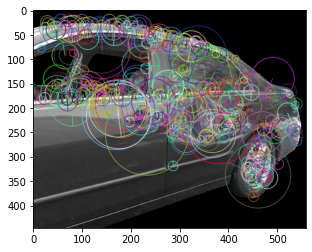

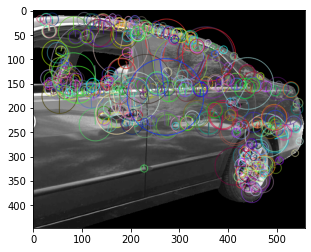

There are:  371  bad matches
There are:  84  good matches.
There are:  455  total matches.
Visualizing the good and bad matches:


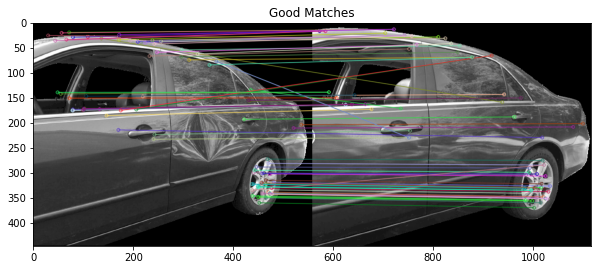

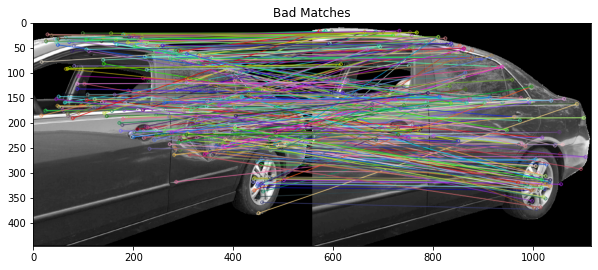

In [ ]:
import os
 
directory_path = 'car_images/blue_car'
imageList = {} # {imgPathName: imgReadAsGreyscale}

for imageFile in os.listdir(directory_path):
    imgPath = os.path.join(directory_path, imageFile)
    if os.path.isfile(imgPath):
        img = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)
        imageList[imgPath] = img

imagePathList = list(imageList.keys())
imageReadList = list(imageList.values())

outputKP = []
outputDES = []

for imgPath in imagePathList:
    kp,des = SURF(imgPath)
    outputKP.append(kp)
    outputDES.append(des)

match_count3,matches3 = feature_match(outputDES[0], outputDES[1])

good3 = [m1 for (m1, m2) in matches3 if m1.distance < 0.75 * m2.distance] # bad matches
bad3 = [m1 for (m1, m2) in matches3 if m1.distance > 0.75 * m2.distance] # bad matches

# print(len(bad3))
# print(len(outputDES[0]), len(outputDES[1]))

# p.float32([ kpts2[m.trainIdx].pt for m in good3 ]).reshape(-1,1,2)
bad_des1 = [outputDES[0][m.queryIdx] for m in bad3]
bad_des2 = [outputDES[1][m.trainIdx] for m in bad3]
    
# bad3Keys = list(bad3.keys())
print("There are: ", len(bad3), " bad matches") # 350 out of 365 are bad matches
print("There are: ", len(good3), " good matches.")
print("There are: ", match_count3, " total matches.") # 69 SURF (hessian=2000), 112 SURF (hessian=1000), 426 SURF color (hessian=100), 450 SURF grayscale (hessian=100)

# Using match:
# result3 = cv2.drawMatches(imageReadList[0], outputKP[0], imageReadList[1], outputKP[1], matches3[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
result3Good = cv2.drawMatches(imageReadList[0], outputKP[0], imageReadList[1], outputKP[1], good3, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
result3Bad = cv2.drawMatches(imageReadList[0], outputKP[0], imageReadList[1], outputKP[1], bad3, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS) # draw the 50 worst matches (greatest distance)

print("Visualizing the good and bad matches:")
plt.figure(figsize=(10, 6))
plt.imshow(result3Good)
plt.title("Good Matches")
plt.show()
plt.figure(figsize=(10, 6))
plt.imshow(result3Bad)
plt.title("Bad Matches")
plt.show()

#### Functions for Finding Transformation Matrix and Masking out Differences in Images

Using the method described in: https://stackoverflow.com/questions/67736244/differences-between-two-images-with-slightly-different-point-of-view-and-lightin/67830242#67830242

In [8]:
def get_matrix(img1, img2, pts):
    surf = cv2.xfeatures2d.SURF_create()
    kpts1, descs1 = surf.detectAndCompute(img1, None)
    kpts2, descs2 = surf.detectAndCompute(img2, None)

    bfMatcher = cv2.BFMatcher()
    matches = bfMatcher.knnMatch(descs1,descs2,k=2)
    matches = sorted(bfMatcher.knnMatch(descs1, descs2, 2), key=lambda x: x[0].distance)
    good = [m1 for m1, m2 in matches if m1.distance < 0.7 * m2.distance]

    resultGood = cv2.drawMatches(img1, kpts1, img2, kpts2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(10, 6))
    plt.imshow(resultGood, cmap='gray')
    plt.show()

    if (len(good) < 5):
        print("not enough matches found")
        return None
    
    src_pts = np.float32([[kpts1[m.queryIdx].pt] for m in good])
    dst_pts = np.float32([[kpts2[m.trainIdx].pt] for m in good])

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5)
    dst = cv2.perspectiveTransform(pts, M).astype('float32')
    return cv2.getPerspectiveTransform(dst, pts)

def get_mask(img):
    mask = np.zeros(img.shape[:2], 'uint8')
    img_canny = cv2.Canny(img, 0, 0)
    img_dilate = cv2.dilate(img_canny, None, iterations=2)
    img_erode = cv2.erode(img_dilate, None, iterations=3)
    _, contours, _ = cv2.findContours(img_erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = cv2.convexHull(max(contours, key=cv2.contourArea))
    cv2.drawContours(mask, [cnt], -1, 255, -1)
    return mask

### Visualizing Feature Matches and Difference Masking

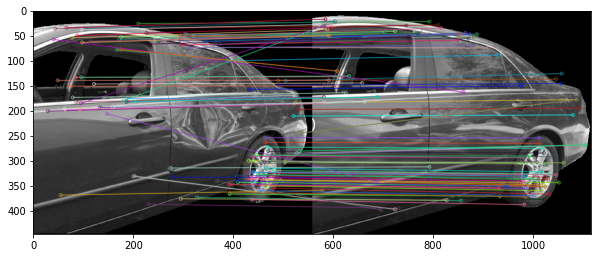

SSIM: 0.6040206663419424


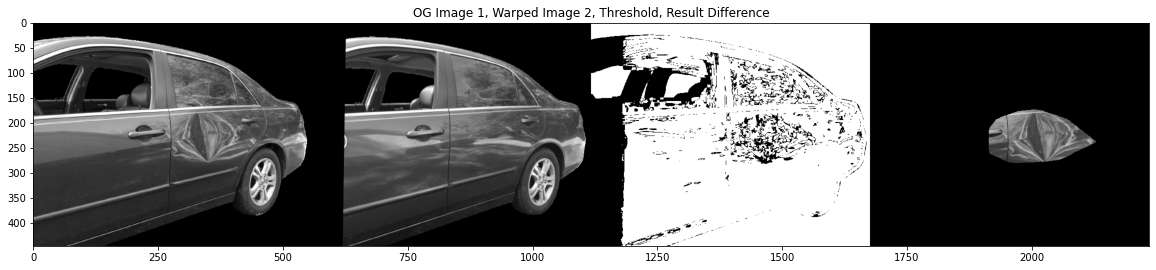

-------------------------------


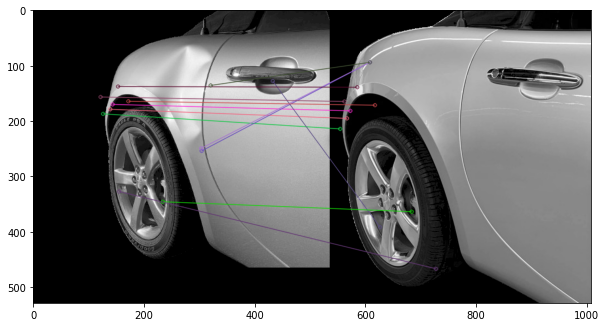

SSIM: 0.4482395001665951


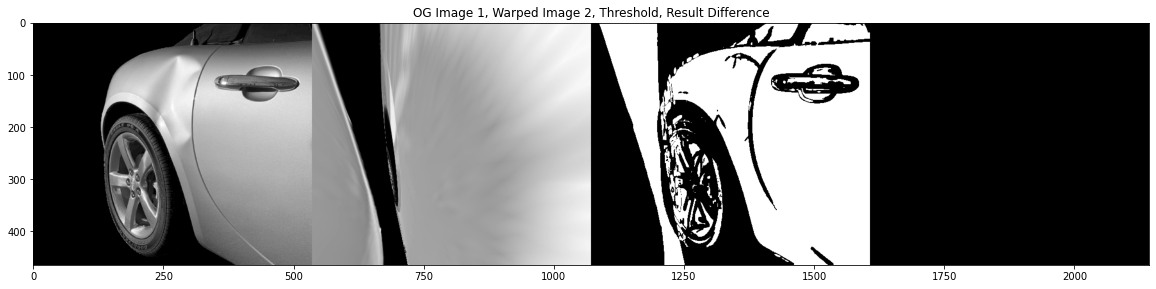

-------------------------------


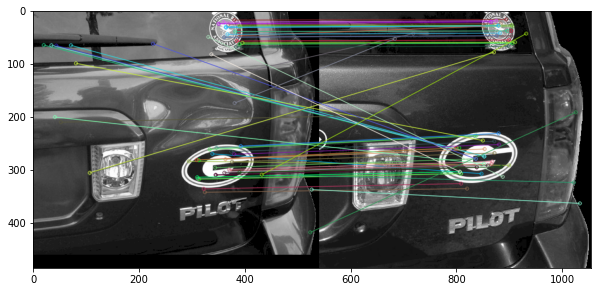

SSIM: 0.2521725042217736


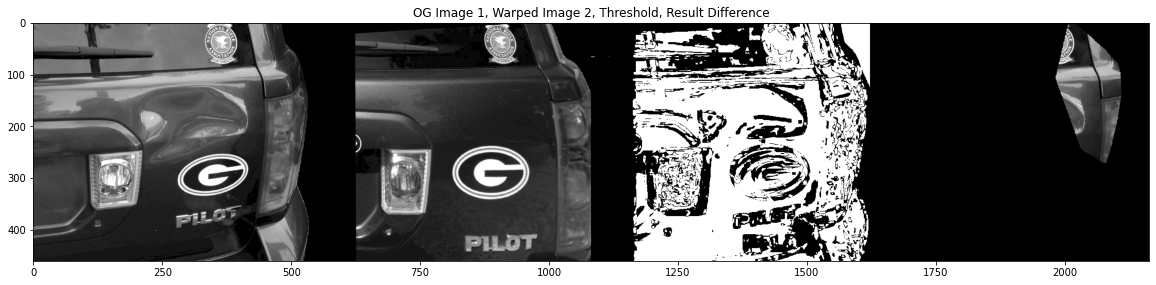

-------------------------------


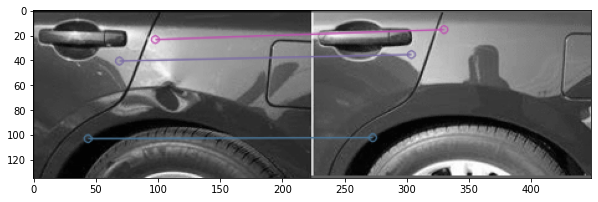

not enough matches found


In [9]:
folder_path = "car_images"
for file_name in os.listdir(folder_path):
    if os.path.isdir(os.path.join(folder_path, file_name)):
        img_filename = os.path.join(folder_path,file_name)
        img1 = cv2.imread(os.path.join(img_filename, "withDent.png"), cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(os.path.join(img_filename, "withoutDent.png"), cv2.IMREAD_GRAYSCALE)

        # print(img1.shape)
        # print(img2.shape)
        h, w= img1.shape

        pts = np.float32([[[0, 0]], [[0, h - 1]], [[w - 1, h - 1]], [[w - 1, 0]]])
        perspectiveM = get_matrix(img1, img2, pts)

        if (perspectiveM is not None):
            warped = cv2.warpPerspective(img2, perspectiveM, (w, h))

            (score,diff) = ssim(warped, img1, full=True)
            print(f'SSIM: {score}') # ~ 0.5
            diff = (diff * 255).astype("uint8")

            _, thresh = cv2.threshold(diff, 40, 255, cv2.THRESH_BINARY) # 40,255
            mask = get_mask(thresh)

            perspectiveM = cv2.warpPerspective(mask, np.linalg.inv(perspectiveM), (w, h))

            # print(img1.shape)
            # print(img2.shape)
            # print(perspectiveM.shape)
            res = cv2.bitwise_and(img1, img1, mask=perspectiveM)


            plt.figure(figsize=(20,12))
            plt.imshow(np.hstack((img1,warped,thresh,res)), cmap='gray')
            plt.title("OG Image 1, Warped Image 2, Threshold, Result Difference")
            plt.show()
            print("-------------------------------")